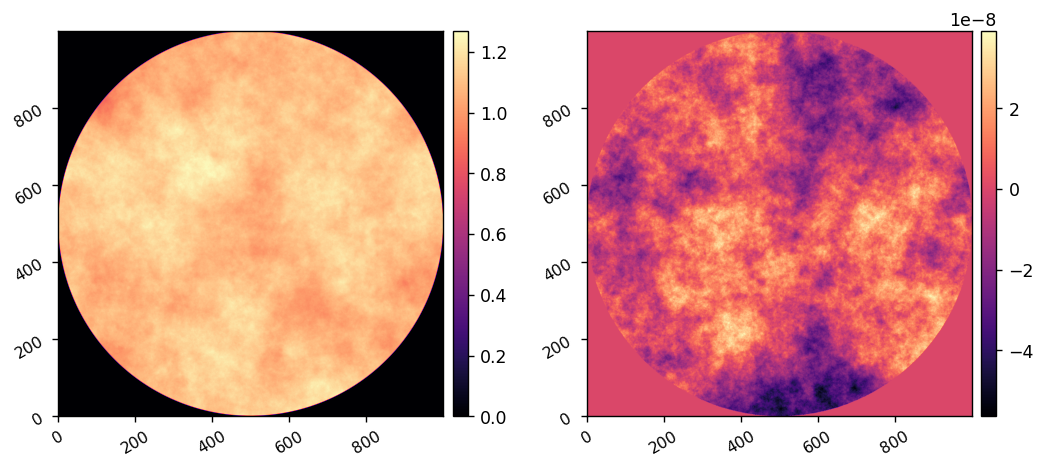

[[6.013500e-07 6.092625e-07 6.171750e-07]
 [6.250875e-07 6.330000e-07 6.409125e-07]
 [6.488250e-07 6.567375e-07 6.646500e-07]]
[6.092625e-07 6.330000e-07 6.567375e-07]


In [10]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from importlib import reload

from scipy.optimize import minimize

import scoobpsf
import scoobpsf.scoob_rmad as rmad
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

import lina
import lina.adefc_bb as adefc

wfe_amp = utils.load_fits('example_wfe_amp.fits')
wfe_opd = utils.load_fits('example_wfe_opd.fits')/2.5
imshow2(wfe_amp, wfe_opd)

Nwaves = 9
wavelength_c = 633e-9
bw = 0.10
waves = np.linspace(wavelength_c * (1-bw/2), wavelength_c * (1+bw/2), Nwaves )
bandpasses = waves.reshape(3,3)
print(bandpasses)

Nwaves_per_bp = bandpasses.shape[1]
est_waves = bandpasses[:, Nwaves_per_bp//2]
print(est_waves)


# Test the forward model parameters.

In [6]:
np.array([633e-9])

array([6.33e-07])

Oversampling > 2x suggested for reliable results in Fresnel propagation.


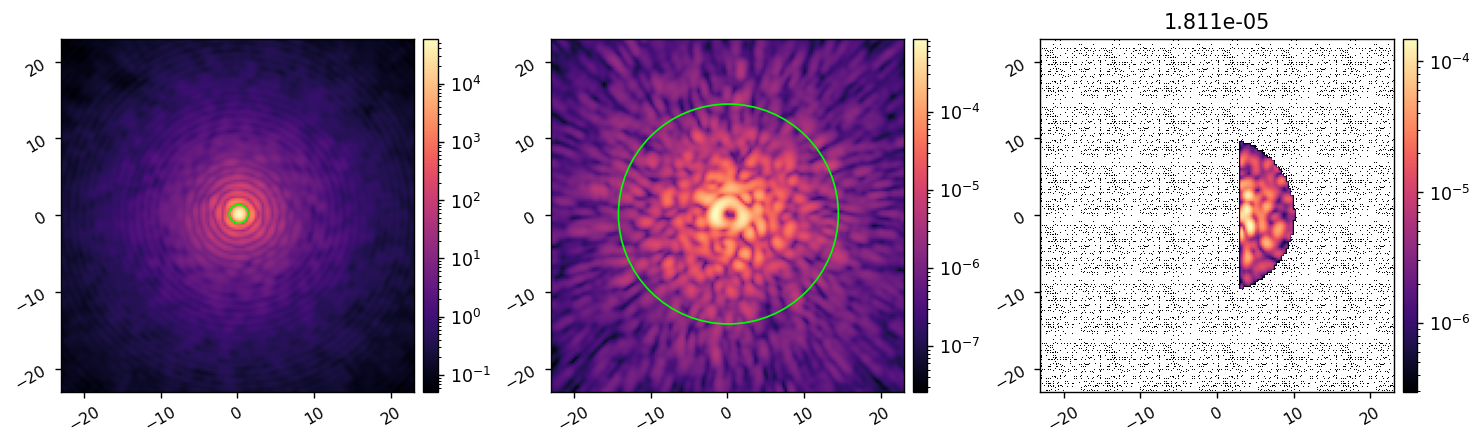

In [24]:
reload(rmad)
I = rmad.MODEL(
    dm_beam_diam=9.4*u.mm, 
    lyot_pupil_diam=9.4*u.mm,
    # dm_shift=np.array([0,0])*u.mm,
    # lyot_shift=np.array([0,0.3])*u.mm,
)
I.AMP = wfe_amp
I.OPD = wfe_opd
I.waves = waves

# I.reverse_lyot = 1
# I.flip_lyot = 1
# I.det_rotation = 178

I.setattr('use_vortex', False)
ref_psf = I.snap()
I.setattr('Imax_ref', xp.max(ref_psf))
I.setattr('use_vortex', True)
ref_coro_im = I.snap()

iwa = 3
owa = 10
rot = 0
control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=iwa, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

psf_center = (I.psf_pixelscale_lamDc/2, I.psf_pixelscale_lamDc/2)
imshow3(ref_psf, ref_coro_im, ref_coro_im*control_mask, '', '', f'{mean_ni:.3e}',
        lognorm=True, pxscl=I.psf_pixelscale_lamDc, 
        patches1=[Circle(psf_center, 1.22, fill=False, color='lime')], 
        patches2=[Circle(psf_center, I.control_rad, fill=False, color='lime')],
        )

Oversampling > 2x suggested for reliable results in Fresnel propagation.


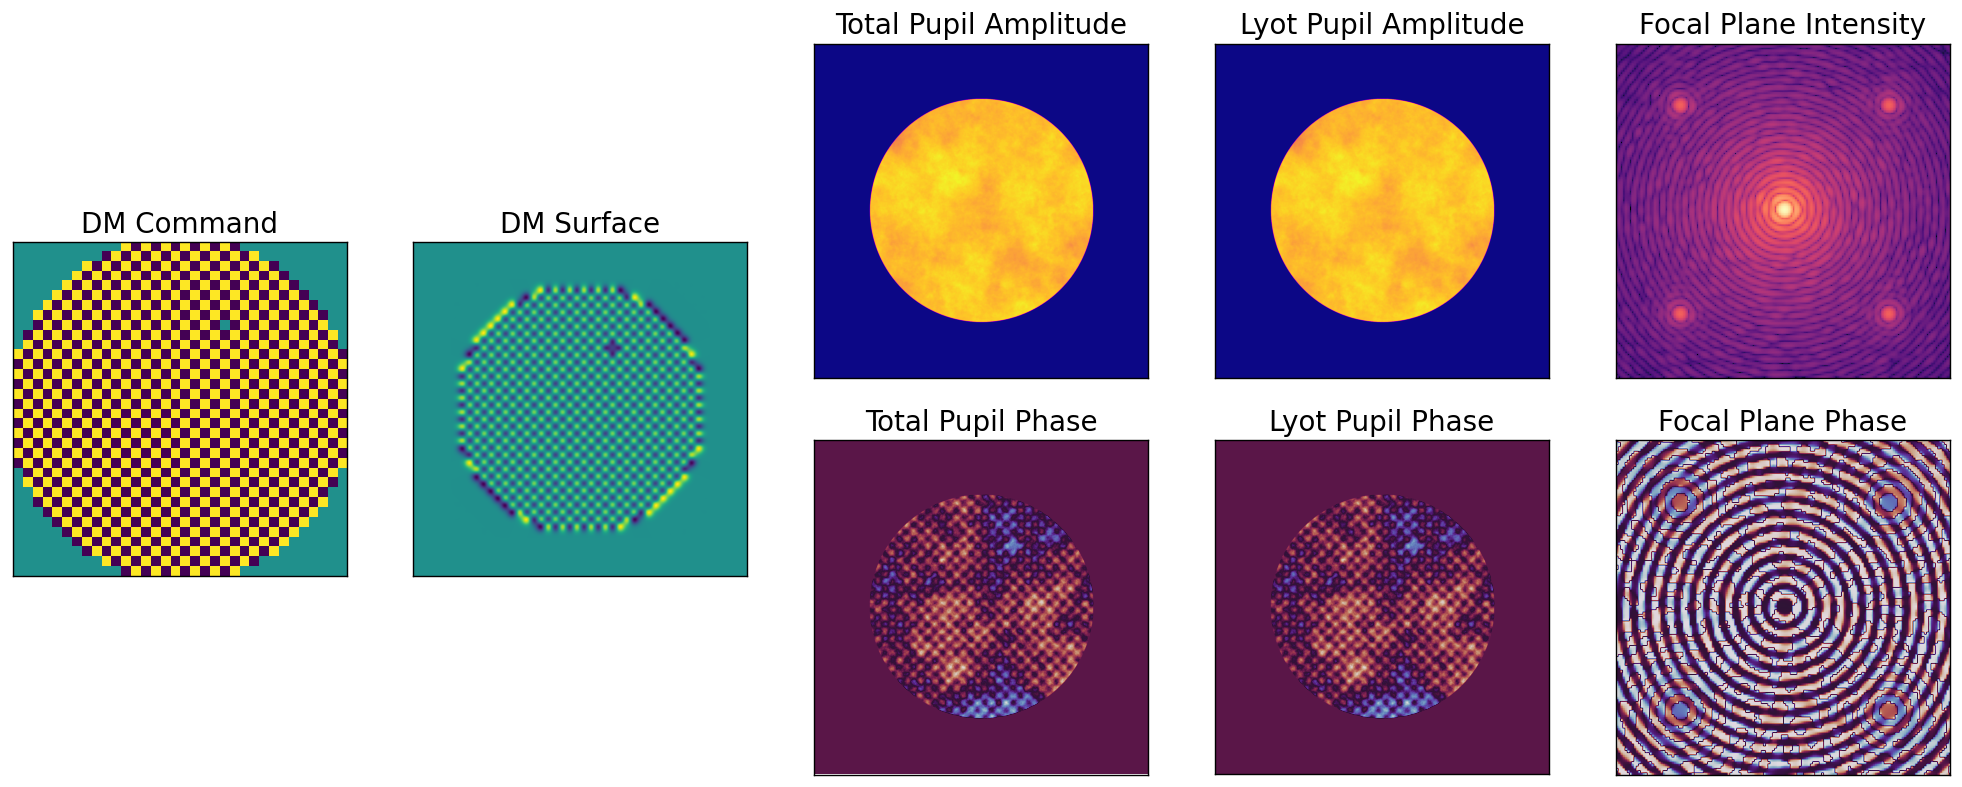

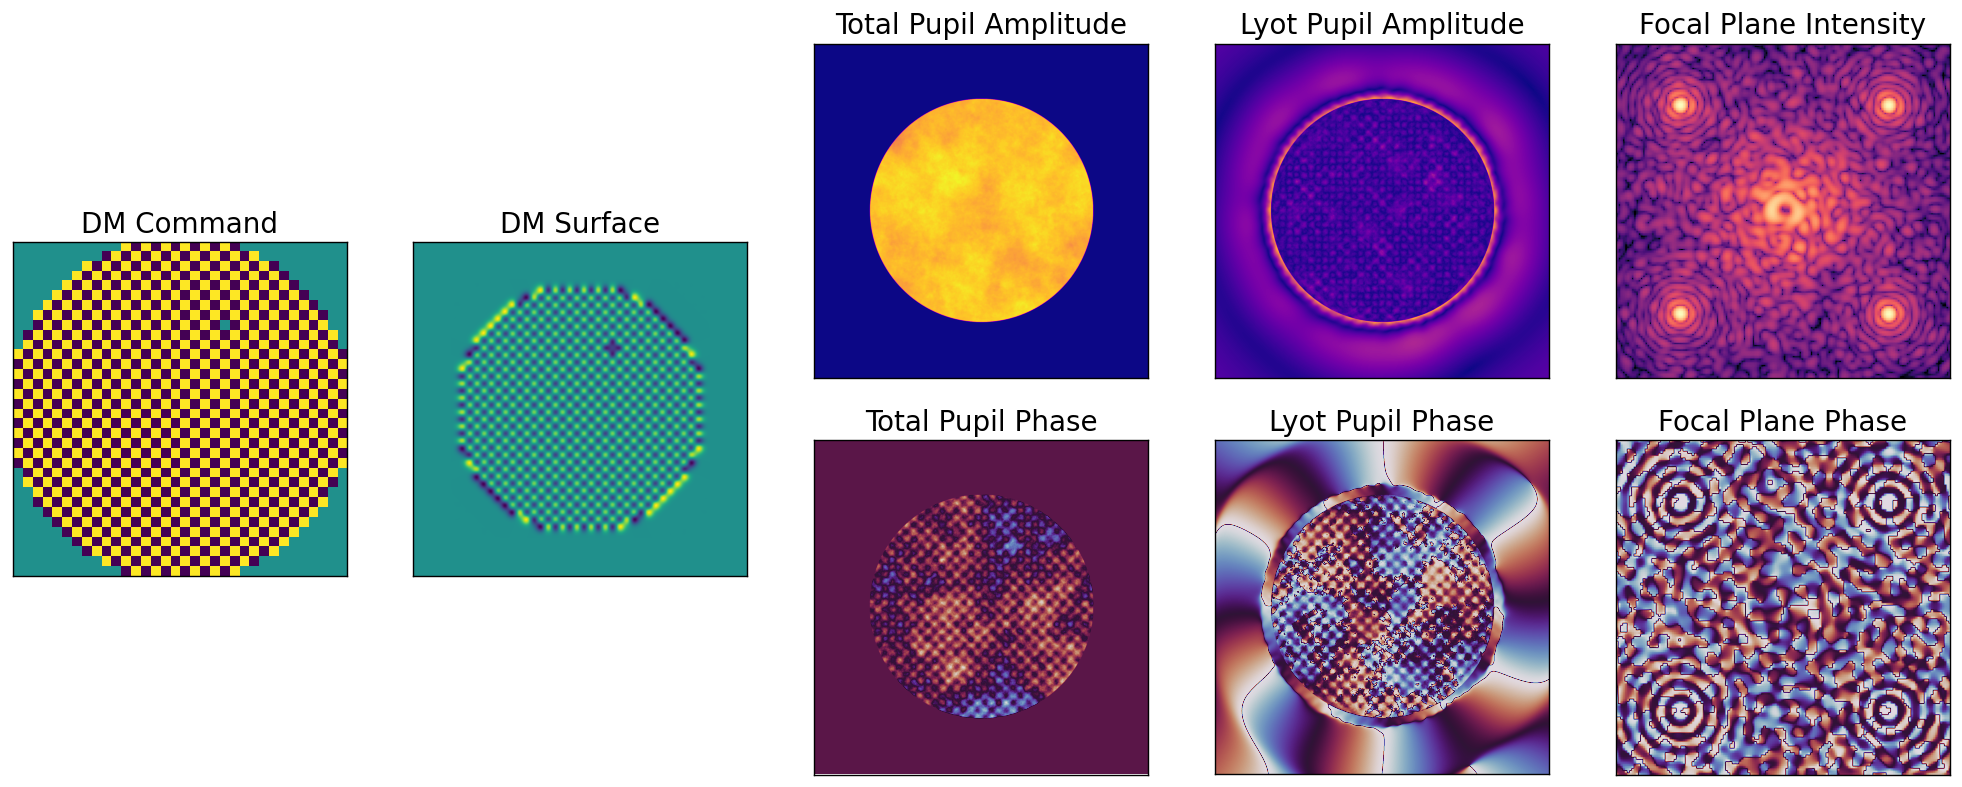

In [12]:
reload(rmad)
reload(scoobpsf.dm)
reload(lina.utils)
M = rmad.MODEL(
    dm_beam_diam=9.4*u.mm, 
    lyot_pupil_diam=9.4*u.mm,
    # dm_shift=np.array([0,0])*u.mm,
    # lyot_shift=np.array([0,0.3])*u.mm,
)
M.AMP = wfe_amp
M.OPD = wfe_opd

# M.reverse_lyot = 1
# M.flip_lyot = 1
# M.det_rotation = 178

M.setattr('use_vortex', False)
ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(ref_psf))

command = np.zeros((M.Nact, M.Nact))
command = 50e-9*lina.utils.make_f(h=10, w=6, shift=(0,0))
command = 20e-9*lina.utils.make_fourier_command(x_cpa=17, y_cpa=17)
fpwf = M.forward(command[M.dm_mask], use_vortex=0, fancy_plot=1)
fpwf = M.forward(command[M.dm_mask], use_vortex=1, fancy_plot=1)


	Cost-function J_delE: 0.018
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.018
	Total cost-function value: 1.000



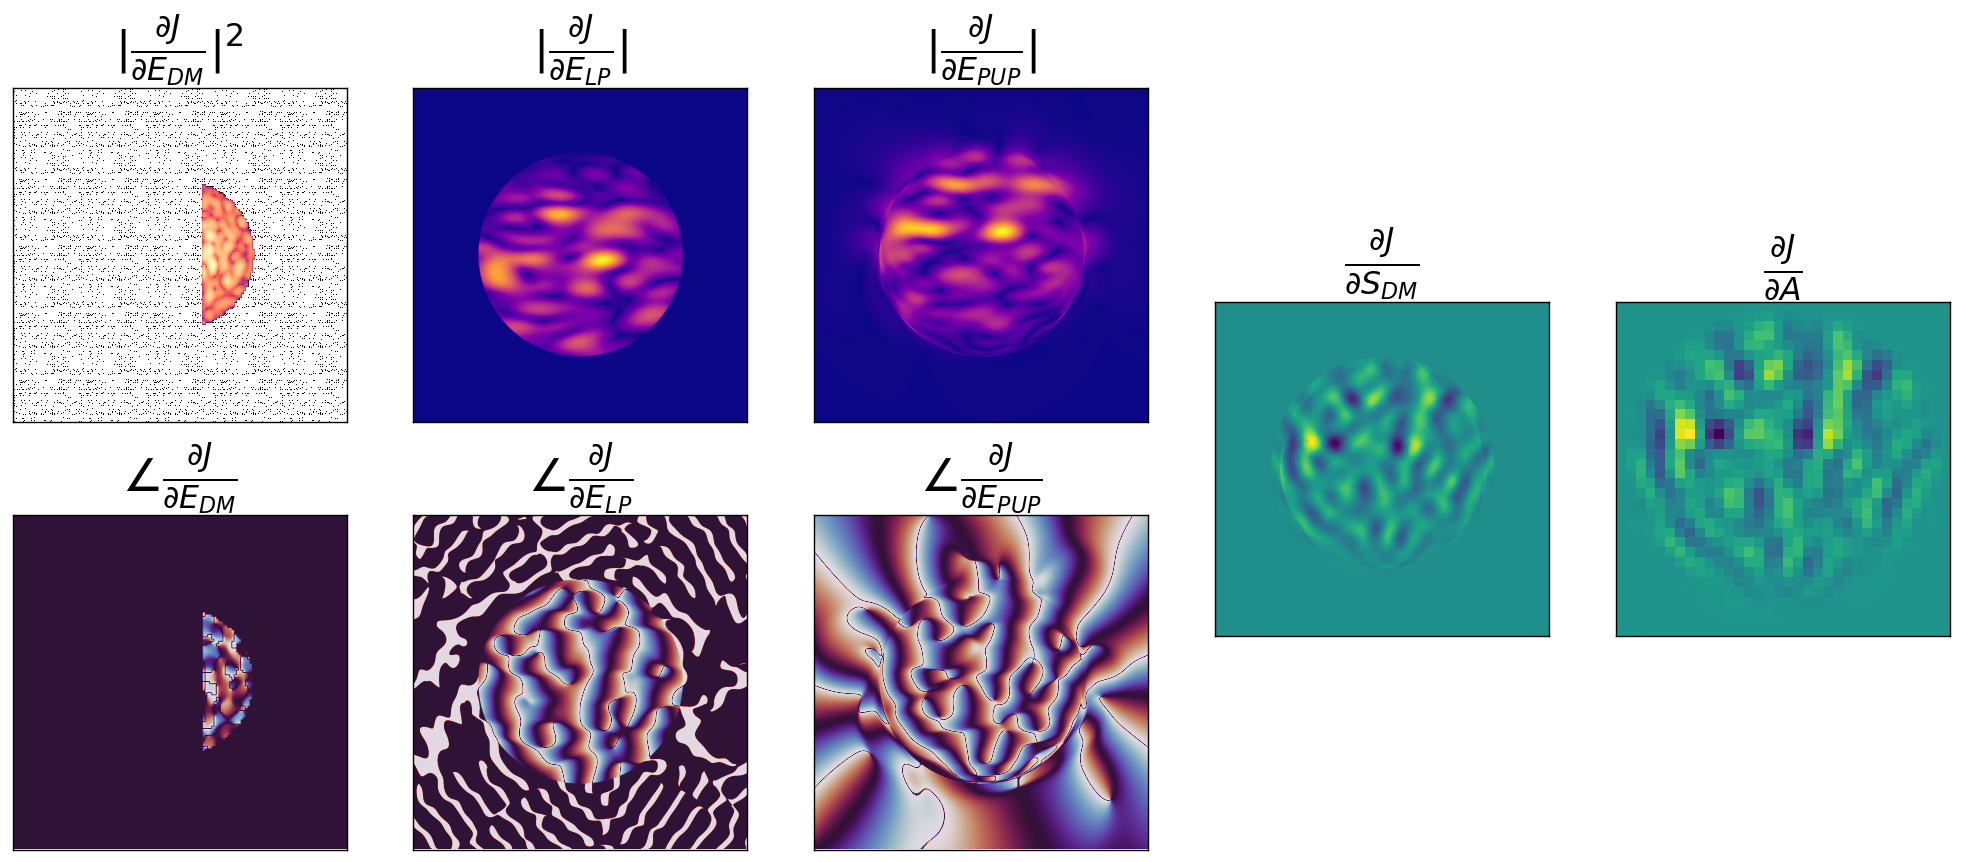

In [13]:
reload(rmad)

acts = np.zeros(I.Nacts)
# acts = fits.getdata('example-data/ad_test_acts.fits')

I.set_dm(rmad.acts_to_command(acts, I.dm_mask))
E_ab = I.calc_wf(I.wavelength_c) * control_mask
r_cond = 1e-3

del_acts = np.zeros(M.Nacts)
# J, dJ_dA = rmad.val_and_grad(del_acts, M, acts, E_ab, r_cond, control_mask, verbose=True, plot=True)
J, dJ_dA = rmad.val_and_grad(del_acts, M, acts, E_ab, control_mask, I.wavelength_c, r_cond, verbose=True, plot=0, fancy_plot=1)
# del_acts, M, actuators, E_ab, control_mask, wavelength, r_cond,

dm_grad = rmad.acts_to_command(dJ_dA, M.dm_mask)
# imshow2(xp.abs(E_ab)**2, dm_grad, lognorm1=True)

In [14]:

acts = np.zeros(I.Nacts)
# acts = fits.getdata('ad_test_acts.fits')

I.set_dm(rmad.acts_to_command(acts, I.dm_mask))
E_ab = I.calc_wf(I.wavelength_c) * control_mask
r_cond = 1e-3

bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(M.Nacts)
res = minimize(rmad.val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(M, acts, E_ab, control_mask, I.wavelength_c, r_cond, True, False), 
                method='L-BFGS-B',
                tol=bfgs_tol,
                options=bfgs_opts,
                )


	Cost-function J_delE: 0.018
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.018
	Total cost-function value: 1.000

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          951     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  5.80832D+06
	Cost-function J_delE: 0.001
	Cost-function J_c: 2495701154.761
	Cost-function normalization factor: 0.018
	Total cost-function value: 135287392183.033

	Cost-function J_delE: 0.012
	Cost-function J_c: 5.114
	Cost-function normalization factor: 0.018
	Total cost-function value: 277.890

	Cost-function J_delE: 0.141
	Cost-function J_c: 0.316
	Cost-function normalization factor: 0.018
	Total cost-function value: 24.775



 This problem is unconstrained.


	Cost-function J_delE: 1.529
	Cost-function J_c: 0.024
	Cost-function normalization factor: 0.018
	Total cost-function value: 84.216

	Cost-function J_delE: 1.872
	Cost-function J_c: 0.001
	Cost-function normalization factor: 0.018
	Total cost-function value: 101.533

	Cost-function J_delE: 0.011
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.018
	Total cost-function value: 0.577


At iterate    1    f=  5.76589D-01    |proj g|=  4.97544D+06
	Cost-function J_delE: 0.001
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.018
	Total cost-function value: 0.056


At iterate    2    f=  5.56127D-02    |proj g|=  5.85668D+05
	Cost-function J_delE: 0.001
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.018
	Total cost-function value: 0.037


At iterate    3    f=  3.65333D-02    |proj g|=  4.45324D+05
	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.018
	Total cost-function value: 0.018


At iterate  

0.0


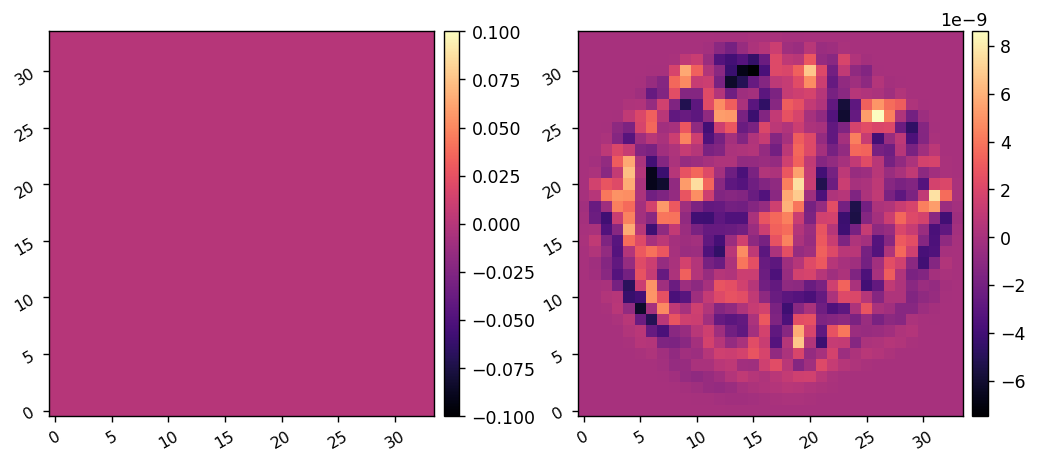

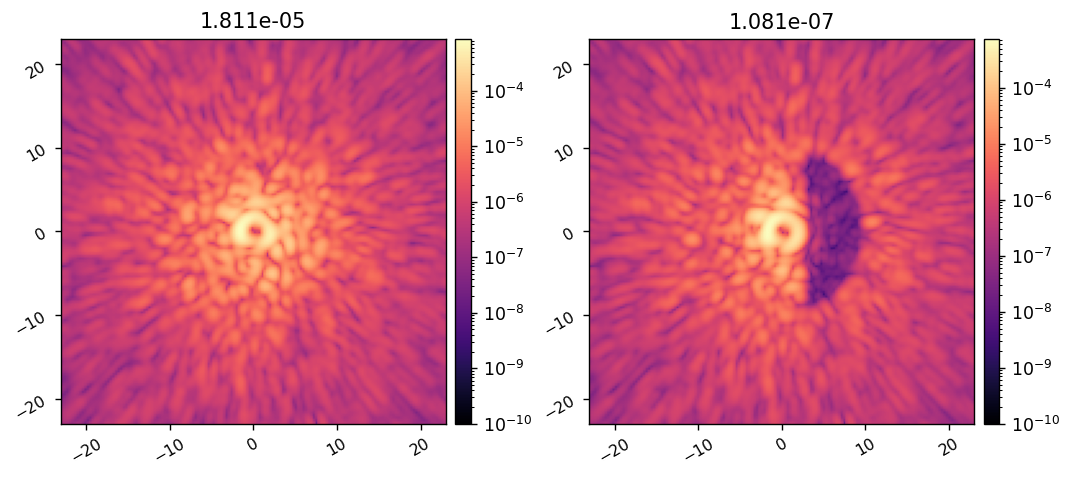

In [15]:
old_command = rmad.acts_to_command(acts, I.dm_mask)
del_command = rmad.acts_to_command(res.x, I.dm_mask)
print(del_command[25,21])

I.set_dm(old_command)
old_im = I.snap()
I.set_dm(old_command + del_command)
new_im = I.snap()

imshow2(old_command, del_command)
imshow2(old_im, new_im, 
        f'{xp.mean(old_im[control_mask]):.3e}', f'{xp.mean(new_im[control_mask]):.3e}',
        lognorm=True, pxscl=I.psf_pixelscale_lamDc, vmin1=1e-10, vmin2=1e-10)

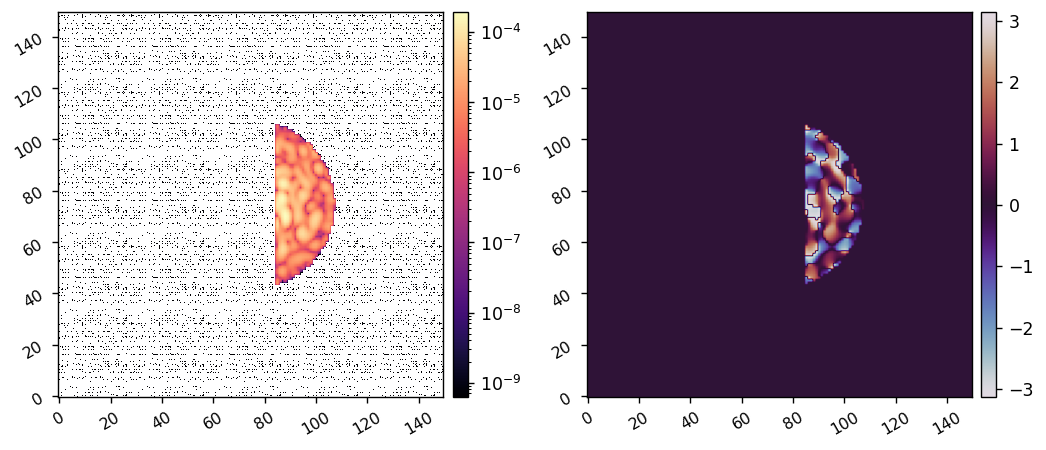

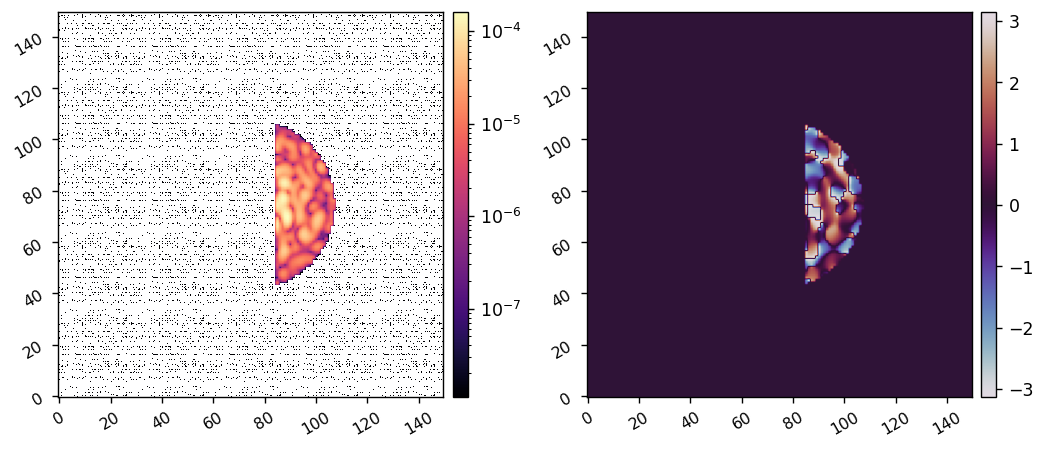

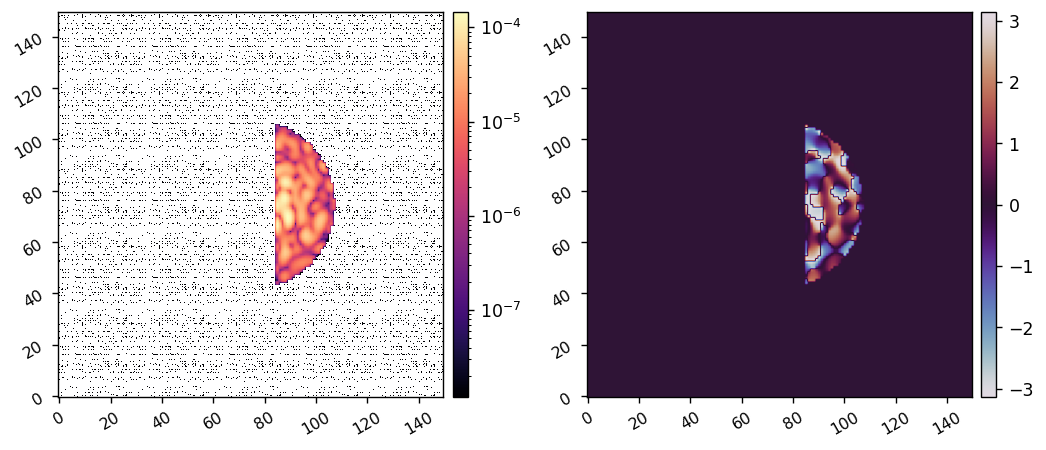

In [16]:
reload(adefc)
I.zero_dm()
E_abs = adefc.calc_wfs(I, est_waves, control_mask, plot=1)

In [17]:
est_waves, bandpasses

(array([6.092625e-07, 6.330000e-07, 6.567375e-07]),
 array([[6.013500e-07, 6.092625e-07, 6.171750e-07],
        [6.250875e-07, 6.330000e-07, 6.409125e-07],
        [6.488250e-07, 6.567375e-07, 6.646500e-07]]))

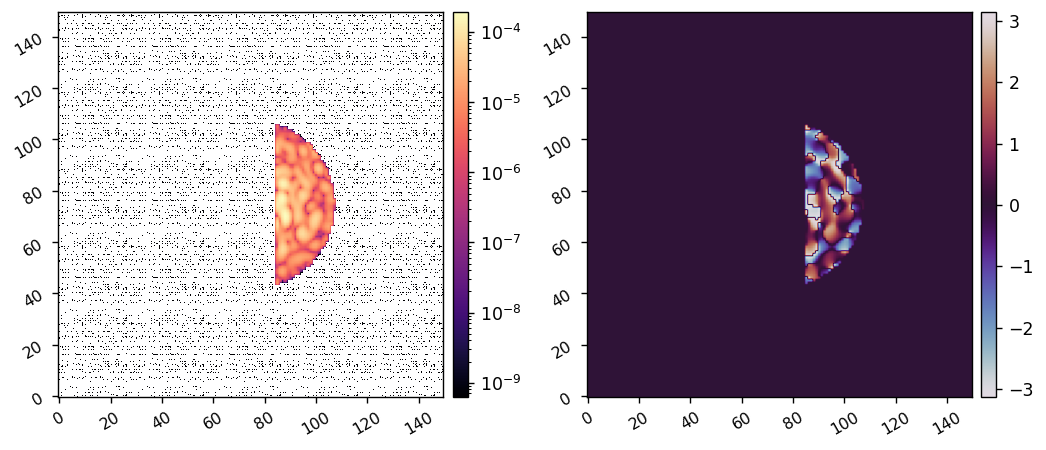

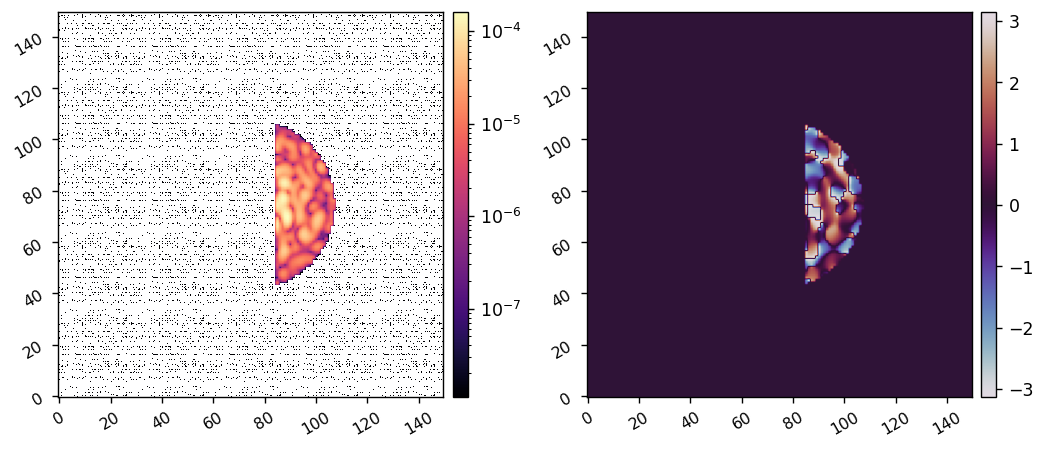

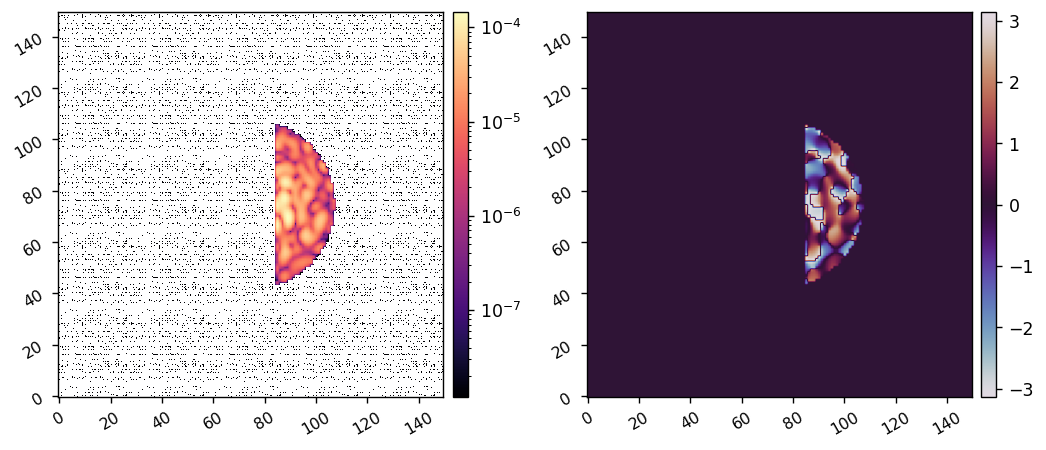

	Cost-function J_delE: 0.020
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.020
	Total cost-function value: 1.000

	Cost-function J_delE: 0.018
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.018
	Total cost-function value: 1.000

	Cost-function J_delE: 0.017
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.017
	Total cost-function value: 1.000



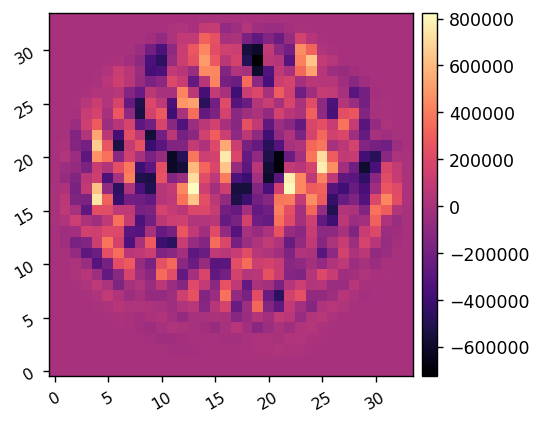

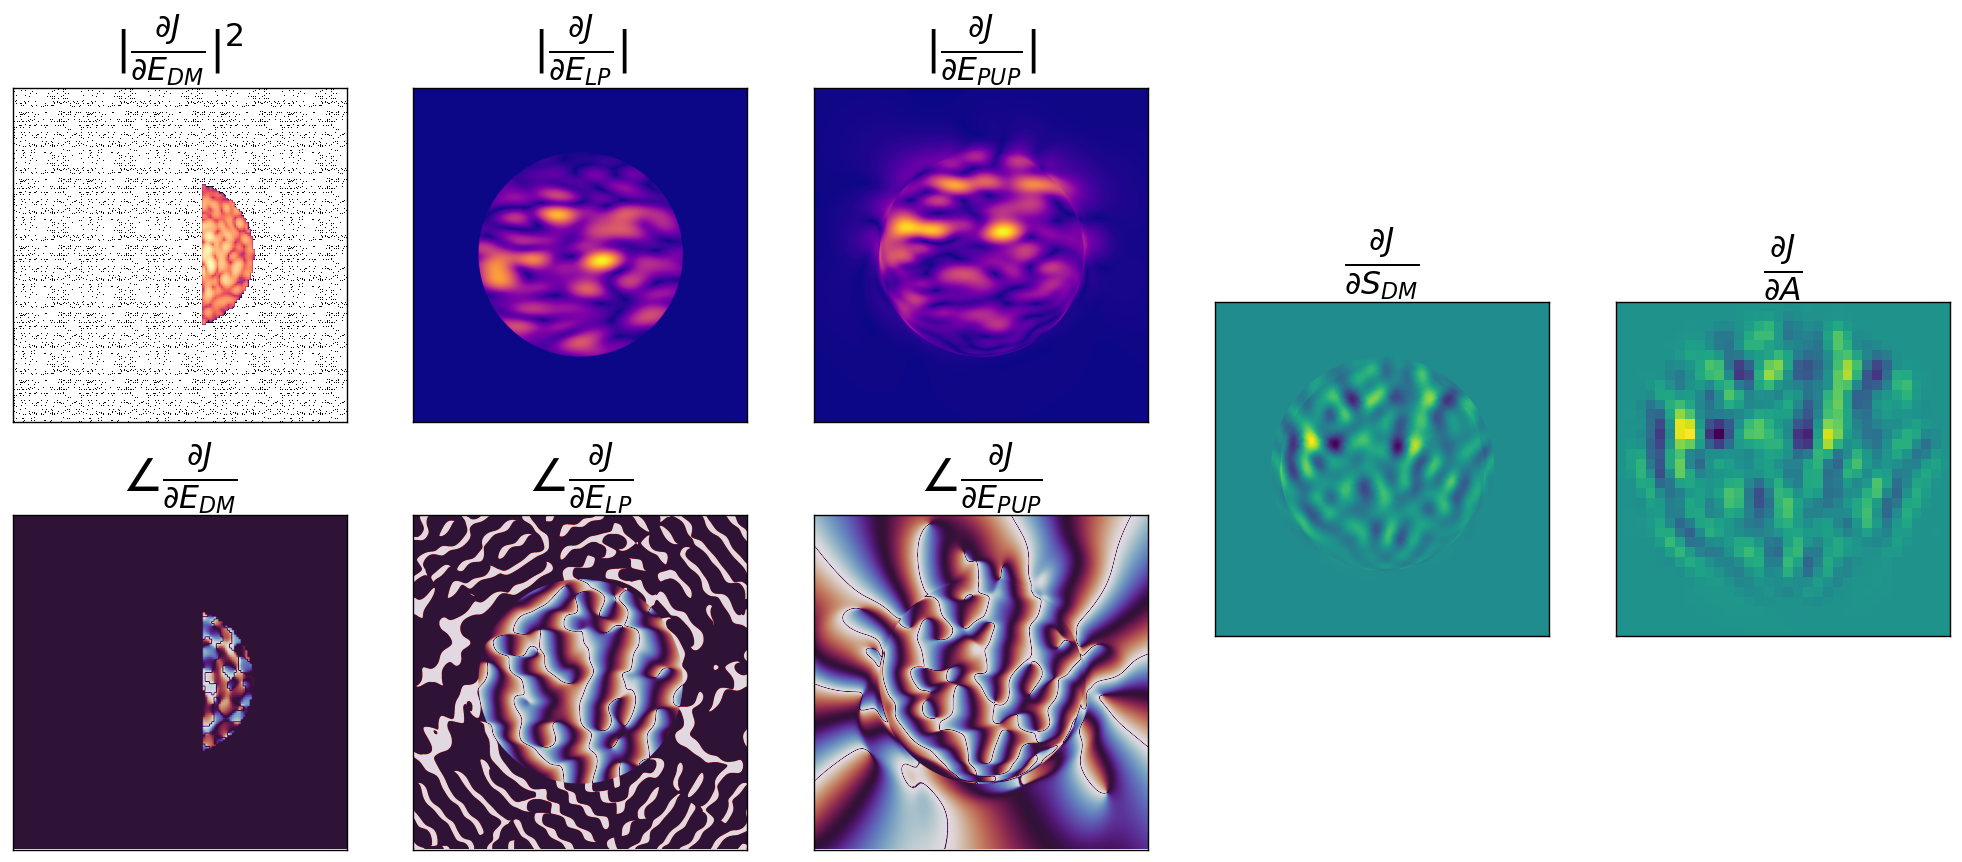

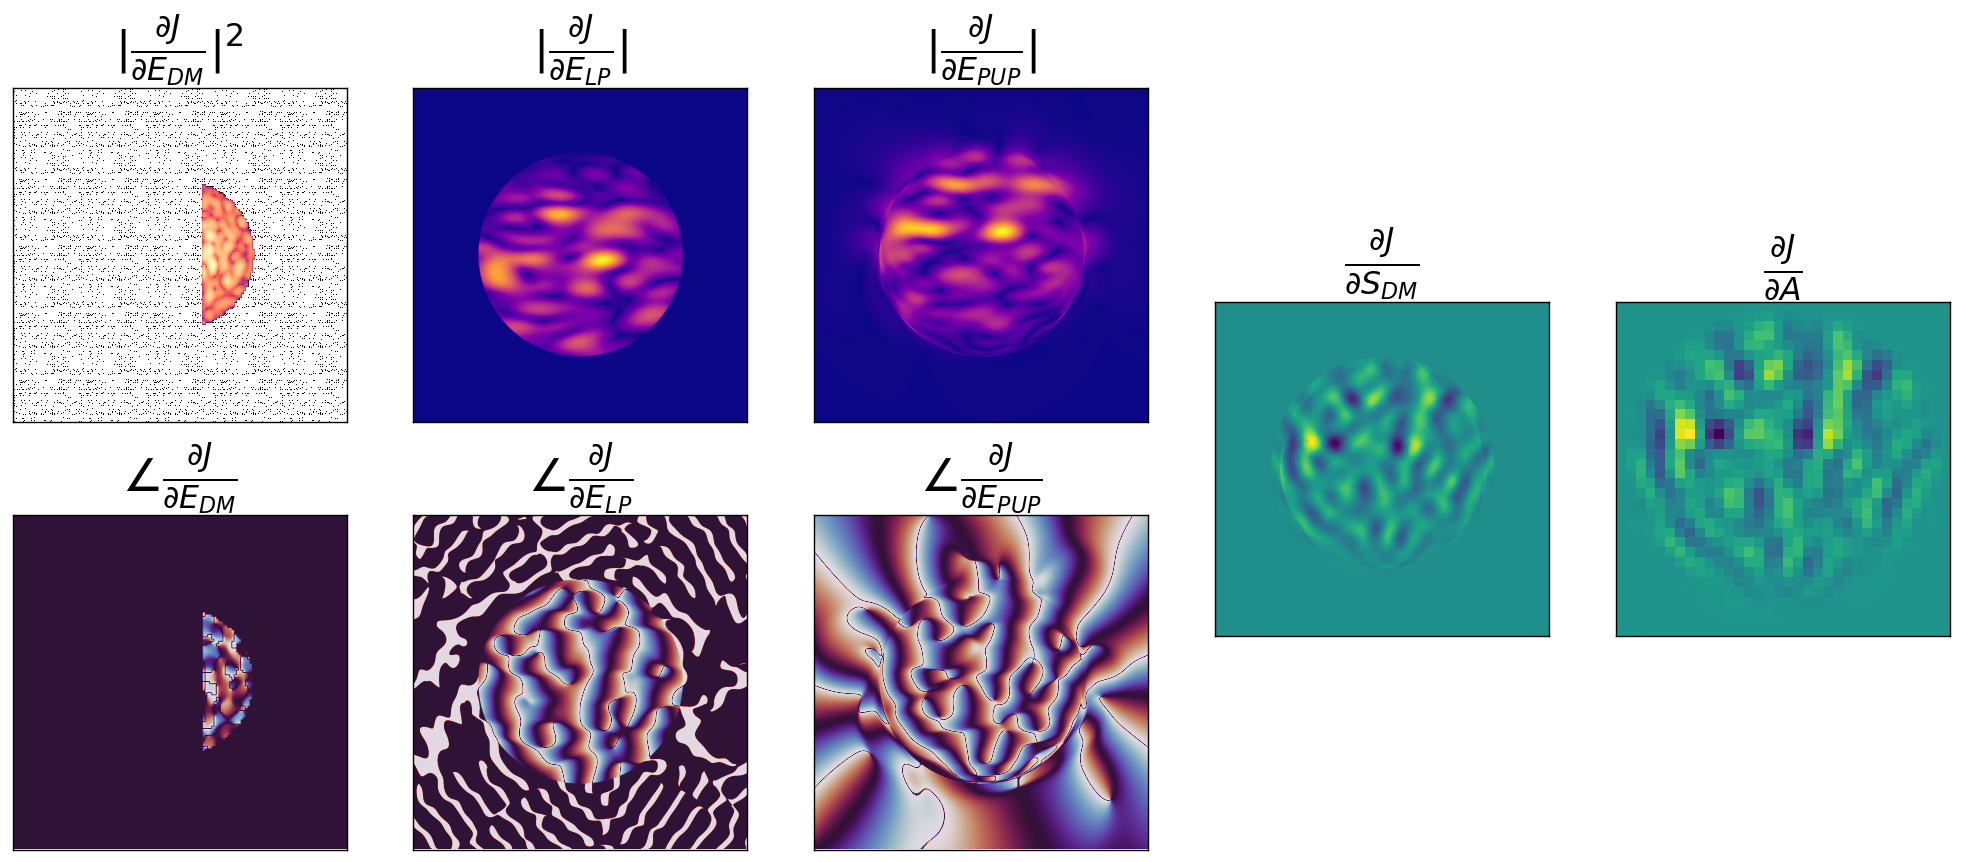

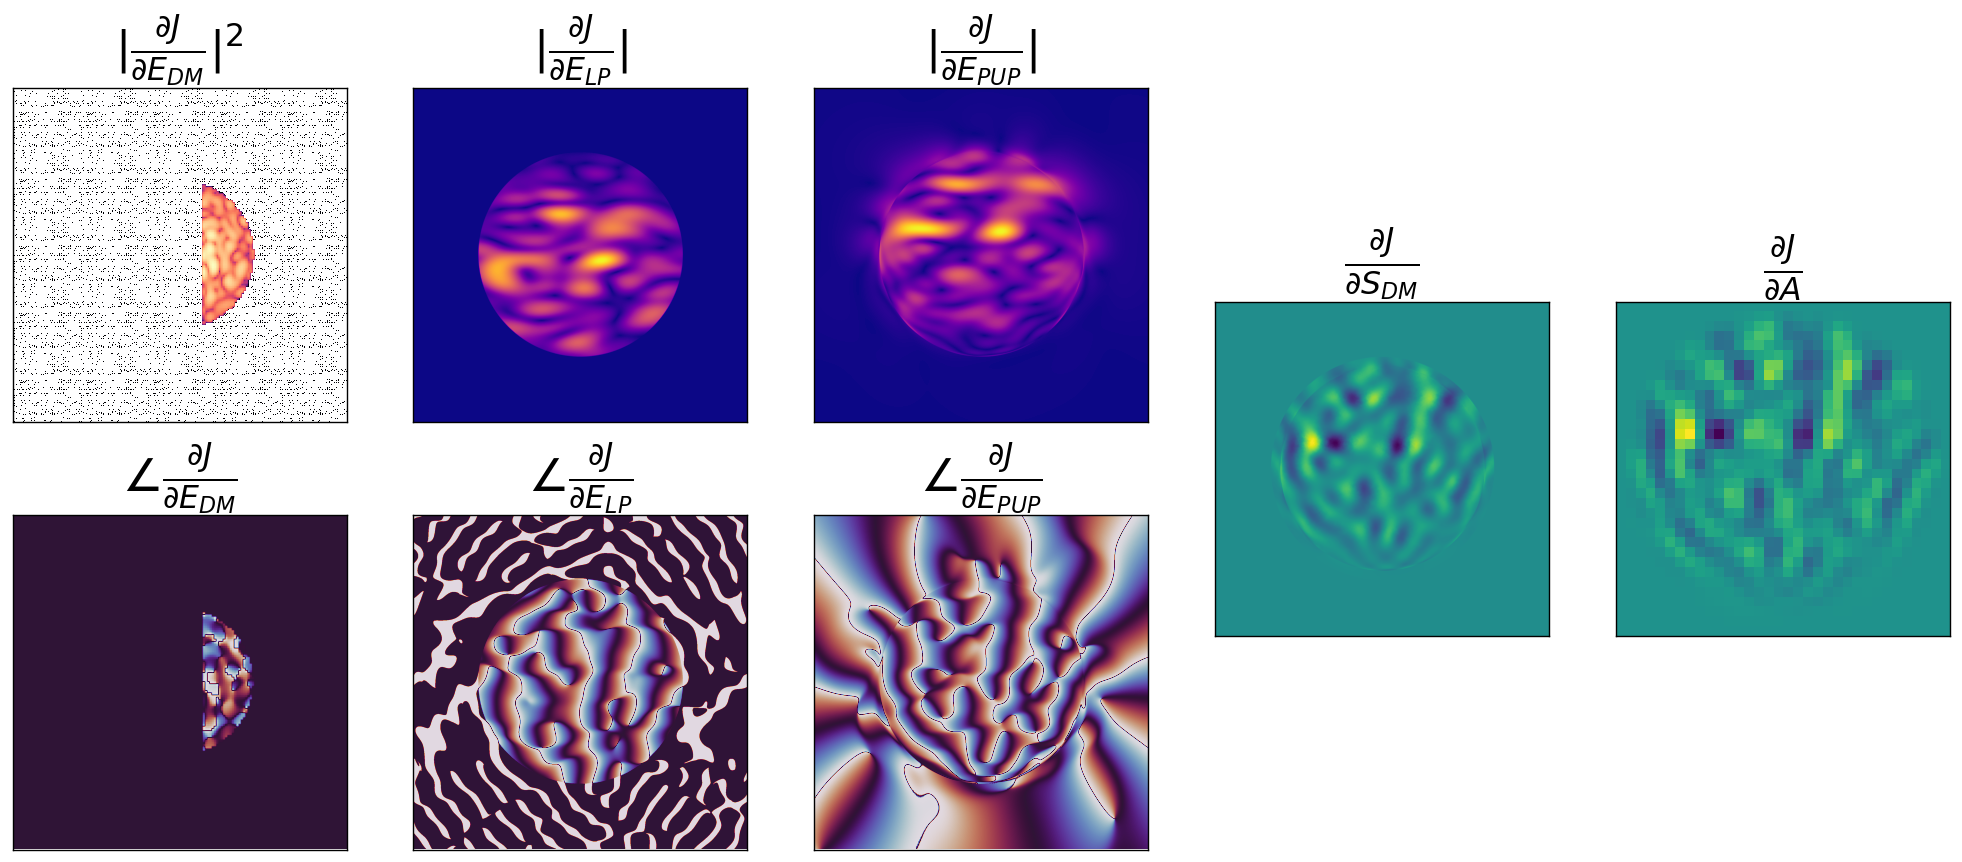

In [20]:
reload(rmad)

acts = np.zeros(I.Nacts)
# acts = fits.getdata('example-data/ad_test_acts.fits')

I.set_dm(rmad.acts_to_command(acts, I.dm_mask))
E_abs = adefc.calc_wfs(I, est_waves, control_mask, plot=1)
r_cond = 1e-3

# del_acts, M, actuators, E_abs, r_cond, control_mask, waves,
del_acts = np.zeros(M.Nacts)
J, dJ_dA = rmad.val_and_grad_bb(del_acts, M, acts, E_abs, control_mask, est_waves, r_cond, verbose=True, plot=0, fancy_plot=1)

dm_grad = rmad.acts_to_command(dJ_dA, M.dm_mask)

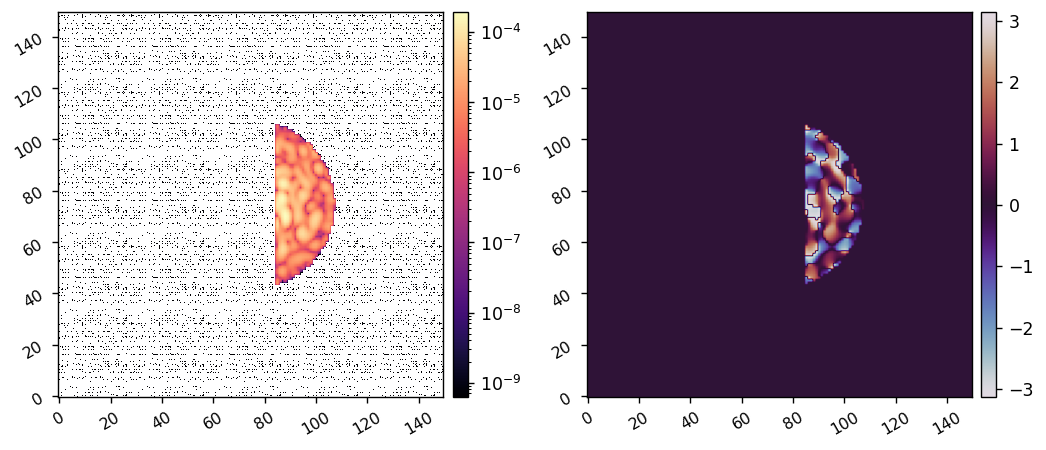

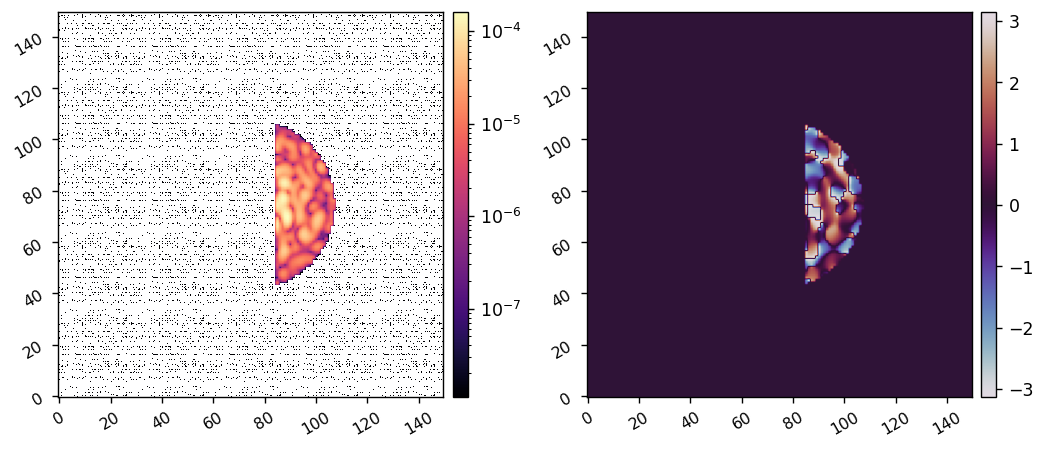

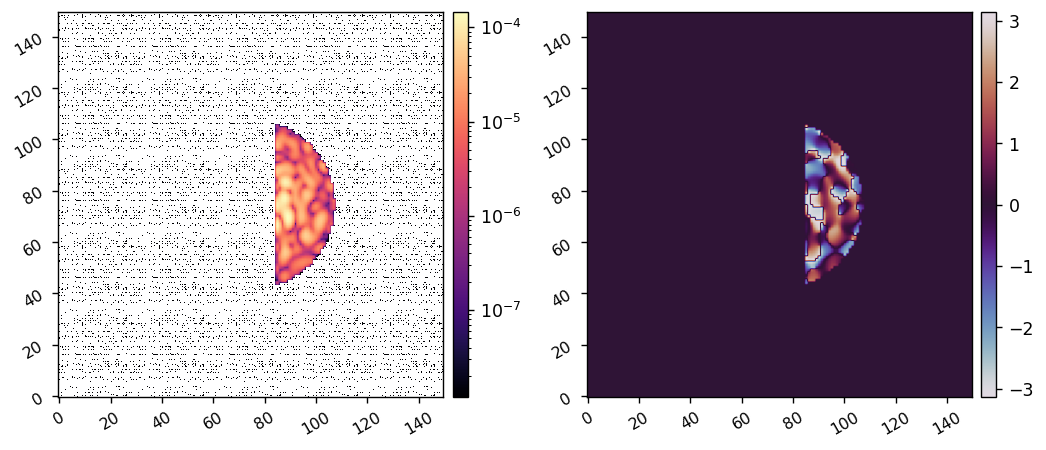

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          951     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  1.72505D+07


 This problem is unconstrained.



At iterate    1    f=  3.28345D-01    |proj g|=  1.04274D+07

At iterate    2    f=  6.03876D-02    |proj g|=  1.76904D+06

At iterate    3    f=  3.92391D-02    |proj g|=  1.35178D+06

At iterate    4    f=  2.02835D-02    |proj g|=  6.20524D+05

At iterate    5    f=  1.31986D-02    |proj g|=  7.12177D+05

At iterate    6    f=  9.39767D-03    |proj g|=  7.16282D+05

At iterate    7    f=  7.21773D-03    |proj g|=  2.70168D+05

At iterate    8    f=  5.81231D-03    |proj g|=  2.69569D+05

At iterate    9    f=  4.41474D-03    |proj g|=  3.27523D+05

At iterate   10    f=  3.83576D-03    |proj g|=  3.64993D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [22]:
reload(rmad)

acts = np.zeros(I.Nacts)
# acts = fits.getdata('ad_test_acts.fits')

I.set_dm(rmad.acts_to_command(acts, I.dm_mask))
E_abs = adefc.calc_wfs(I, est_waves, control_mask, plot=1)
r_cond = 1e-3

bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(M.Nacts)
res = minimize(rmad.val_and_grad_bb, 
                jac=True, 
                x0=del_acts0,
                args=(M, acts, E_abs, control_mask, est_waves, r_cond, True, False), 
                method='L-BFGS-B',
                tol=bfgs_tol,
                options=bfgs_opts,
                )

0.0


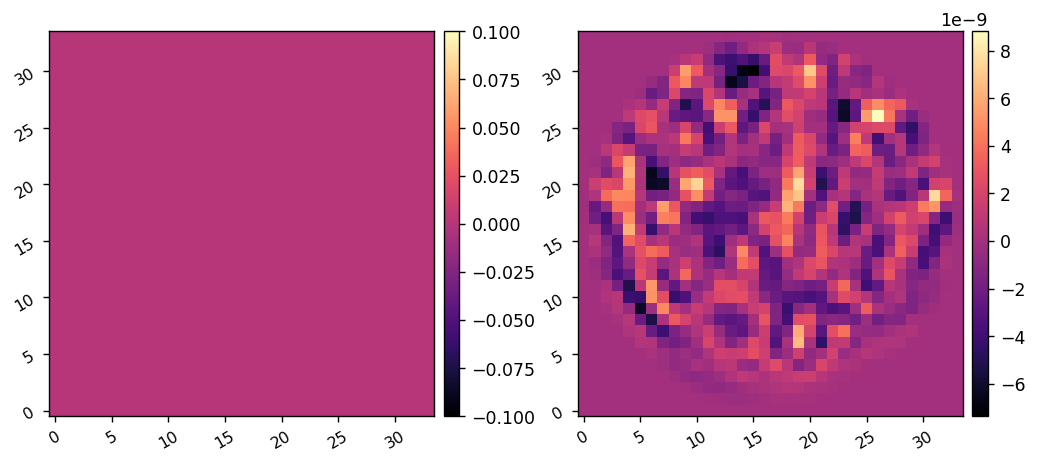

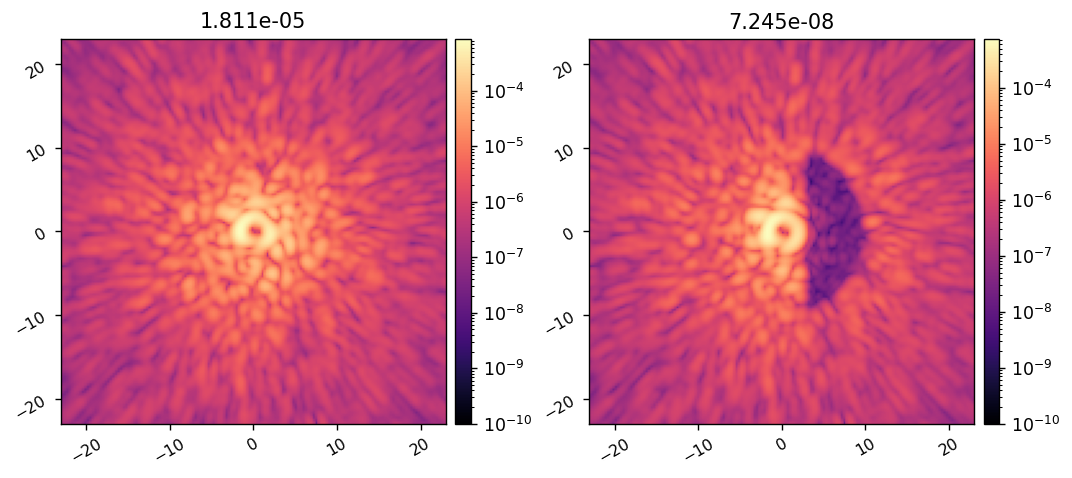

In [23]:
old_command = rmad.acts_to_command(acts, I.dm_mask)
del_command = rmad.acts_to_command(res.x, I.dm_mask)
print(del_command[25,21])

I.set_dm(old_command)
old_im = I.snap()
I.set_dm(old_command + del_command)
new_im = I.snap()

imshow2(old_command, del_command)
imshow2(old_im, new_im, 
        f'{xp.mean(old_im[control_mask]):.3e}', f'{xp.mean(new_im[control_mask]):.3e}',
        lognorm=True, pxscl=I.psf_pixelscale_lamDc, vmin1=1e-10, vmin2=1e-10)

In [36]:
utils.save_fits('ad_test_acts.fits', I.get_dm()[I.dm_mask])

Saved data to:  ad_test_acts.fits
